<a href="https://colab.research.google.com/github/komorimasashi/time_series_book/blob/main/chapter3/Chapter_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 時系列の回帰分析

必要なパッケージのインストール

In [11]:
targetPackages <- c('CADFtest','forecast','lmtest','nlme','tsModel','MARSS','tseries','coronavirus') 
newPackages <- targetPackages[!(targetPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages)


Call:
lm(formula = y ~ x)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.2017 -1.3387  0.0728  1.2181  3.7070 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.13281    0.30544   6.983 3.49e-10 ***
x           -0.29031    0.04672  -6.214 1.26e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.745 on 98 degrees of freedom
Multiple R-squared:  0.2826,	Adjusted R-squared:  0.2753 
F-statistic: 38.61 on 1 and 98 DF,  p-value: 1.261e-08


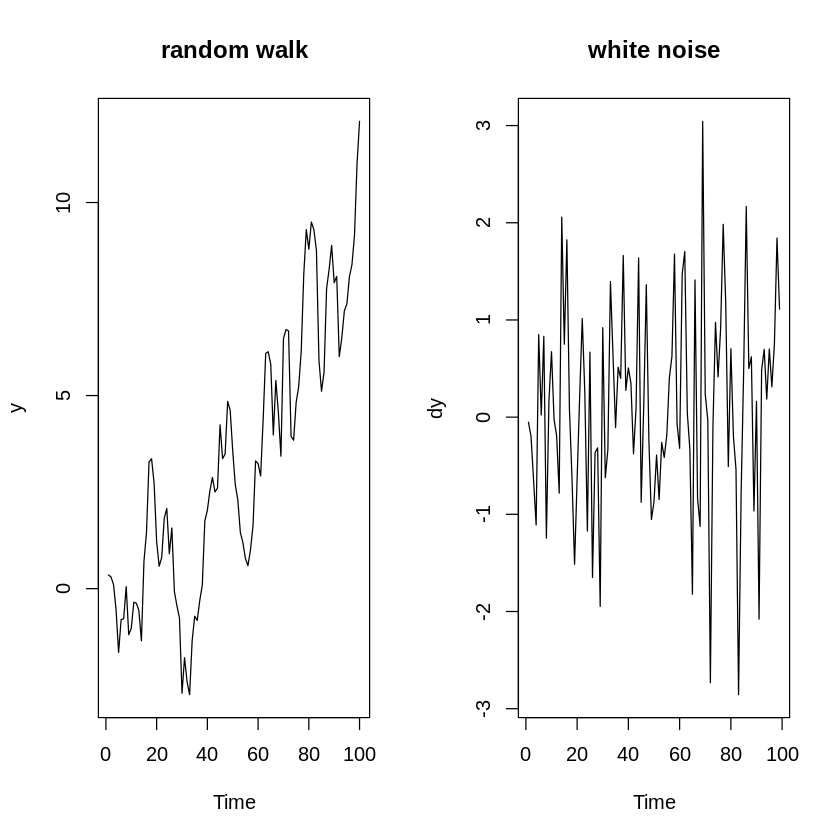

In [12]:
# 3.2.1 単位根過程

y <- cumsum(rnorm(100)) # ランダムウォーク
dy <- diff(y) # ランダムウォークの1階差分
par(mfrow = c(1,2))
ts.plot(y, main="random walk")
ts.plot(dy, main="white noise")


# 見せかけの回帰（何度か実行すると多くの場合に回帰係数が有意になることがわかります）
x <- cumsum(rnorm(100)) # ランダムウォーク
y <- cumsum(rnorm(100)) # ランダムウォーク
summary(lm(y~x)) # 最小二乗法による回帰


In [13]:
# 3.2.2 単位根過程の検定

library(CADFtest)
set.seed(1234)
# ランダムウォークする時系列データを作成します
y <- cumsum(rnorm(200))

# ADF検定
CADFtest(y,
         type='trend', # 定数項もトレンド項もある
         max.lag.y=5, # ラグの最大次数を指定
         criterion='AIC' # ラグ次数はAIC規準で選ぶ
)

# ADF検定
CADFtest(diff(y), # 1階差分系列
         type='trend', # トレンド項も定数項もあり
         max.lag.y=5, # ラグの最大次数を指定
         criterion='AIC' # ラグ次数はAIC規準で選ぶ
)

library(forecast)
ndiffs(y)


	ADF test

data:  y
ADF(1) = -2.4454, p-value = 0.3551
alternative hypothesis: true delta is less than 0
sample estimates:
      delta 
-0.03109597 



	ADF test

data:  diff(y)
ADF(0) = -12.001, p-value < 2.2e-16
alternative hypothesis: true delta is less than 0
sample estimates:
     delta 
-0.8763024 


[1] 1

In [14]:
# 3.3.2 ダービン - ワトソン検定

library(lmtest)

# AR(1)過程のシミュレーション
AR1_model <- list(order = c(1, 0, 0), ar = 0.9)
AR1_sm <- arima.sim(n = 100, model = AR1_model, sd = 1)
fit <- lm(AR1_sm ~1)

# ダービン-ワトソン検定
dwtest(fit)



	Durbin-Watson test

data:  fit
DW = 0.29932, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is greater than 0


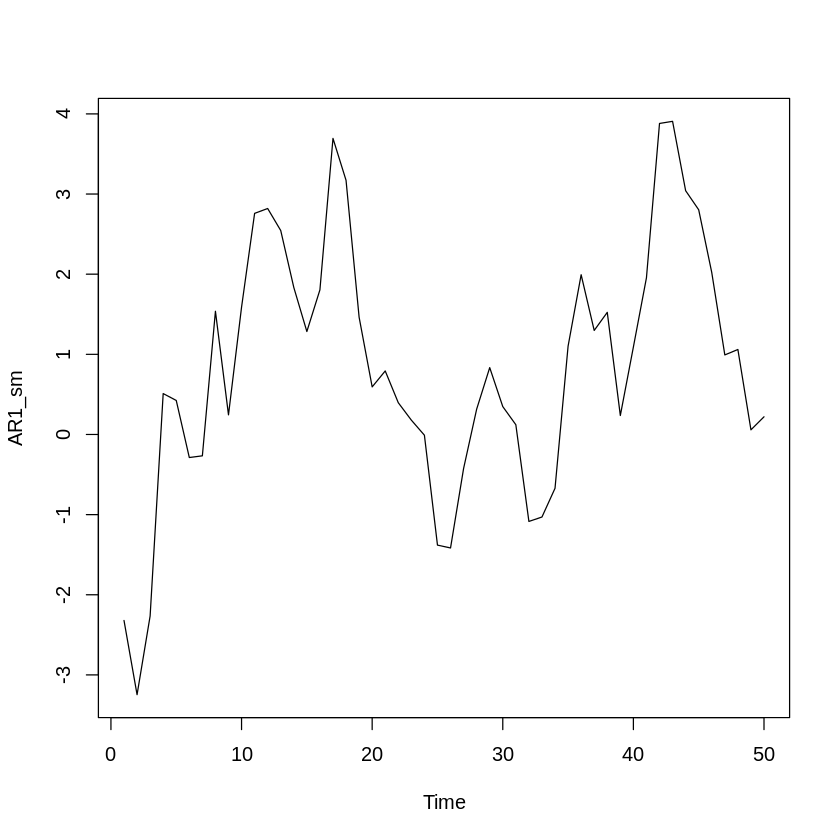


	Durbin-Watson test

data:  fit.lm
DW = 0.41419, p-value = 1.775e-13
alternative hypothesis: true autocorrelation is greater than 0


Generalized least squares fit by REML
  Model: AR1_sm ~ x 
  Data: NULL 
       AIC      BIC    logLik
  147.1331 154.6179 -69.56656

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.8937566 

Coefficients:
                 Value Std.Error    t-value p-value
(Intercept) -0.7284543 1.8414575 -0.3955857  0.6942
x            0.0428709 0.0577929  0.7418023  0.4618

 Correlation: 
  (Intr)
x -0.8  

Standardized residuals:
       Min         Q1        Med         Q3        Max 
-1.2179507 -0.2042175  0.1800353  0.7233767  1.7278467 

Residual standard error: 2.137868 
Degrees of freedom: 50 total; 48 residual

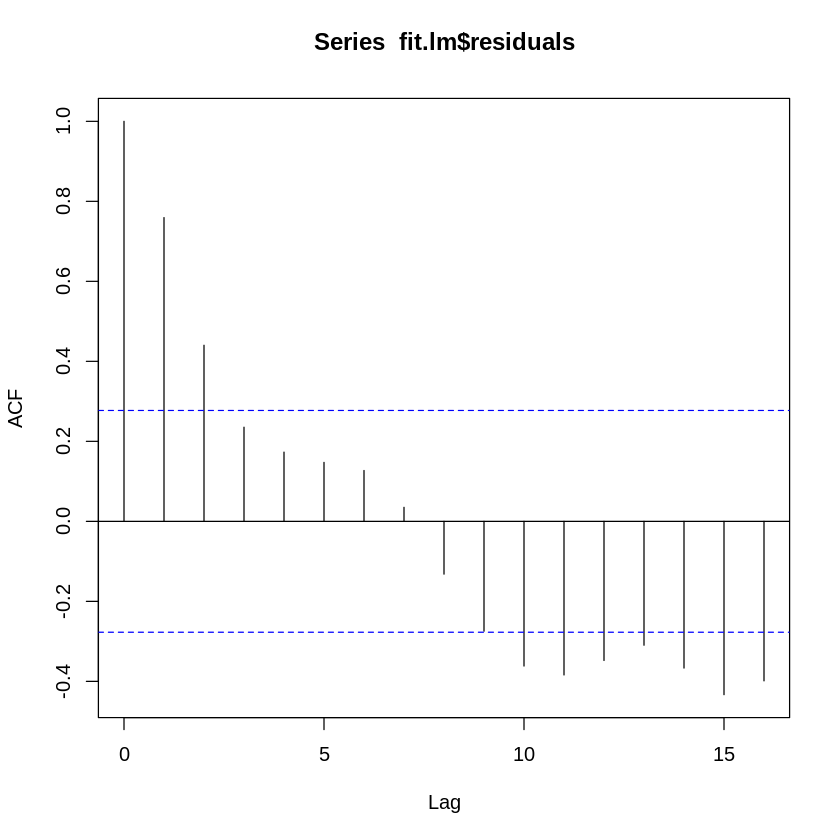

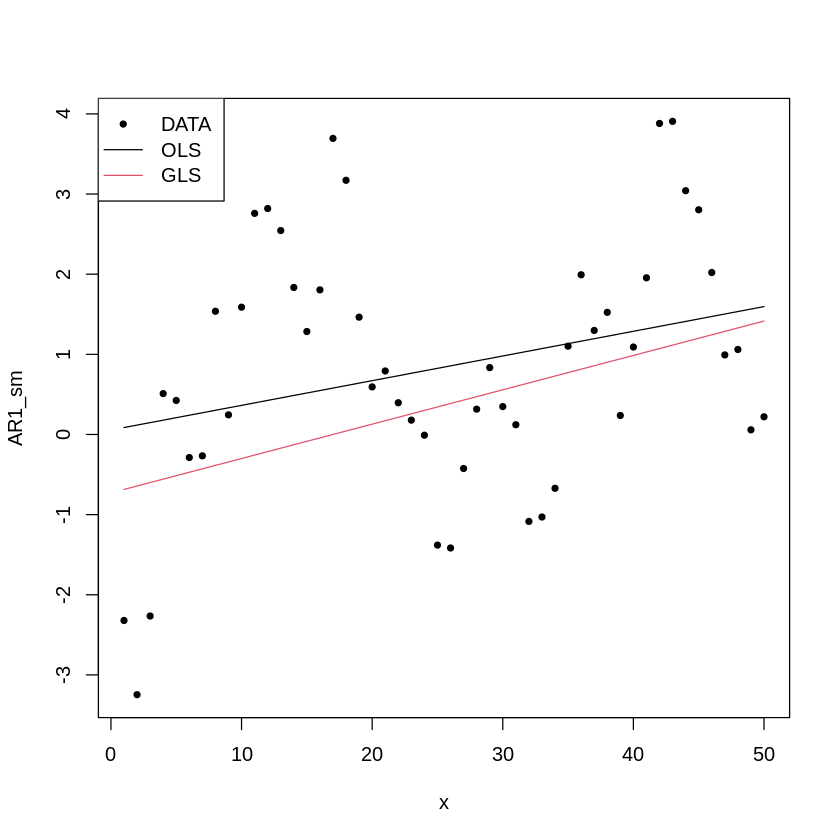

In [15]:
# 3.3.3 一般化最小二乗法

library(lmtest)
library(nlme)

set.seed(1234)
n=50 # 50時点のデータを作成します
x <- seq(50)
# AR(1)過程のシミュレーション
AR1_model <- list(order = c(1, 0, 0), ar = 0.9)
AR1_sm <- arima.sim(n = n, model = AR1_model, sd = 1)
ts.plot(AR1_sm)
# 普通にOLSで回帰分析を行います
fit.lm <- lm(AR1_sm ~ x)
# 残差の自己相関
acf(fit.lm$residuals)
# ダービン-ワトソン検定
dwtest(fit.lm)

# 一般化最小二乗法（GLS）で回帰分析
# correlationパラメータには残差の分散共分散行列のモデルを指定できる
# corAR1()は残差がAR(1)に従うという意味
fit.gls <- gls(AR1_sm ~ x, correlation = corAR1())
# fit.gls <- gls(AR1_sm ~ x, correlation = corARMA(p=1, q=0))　と書いてもよい
summary(fit.gls)

# OLSとGLSの回帰直線の違いを見る
plot(x, AR1_sm, pch=20)
lines(x, predict(fit.lm), col=1, lty=1)
lines(x, predict(fit.gls), col=2, lty=1)
legend("topleft", legend=c("DATA","OLS", "GLS"), col=c(1,1,2),pch=c(20,NA,NA),lty=c(0,1,1))


Warning message in xy.coords(x, y, xlabel, ylabel, log):
“10 y values <= 0 omitted from logarithmic plot”


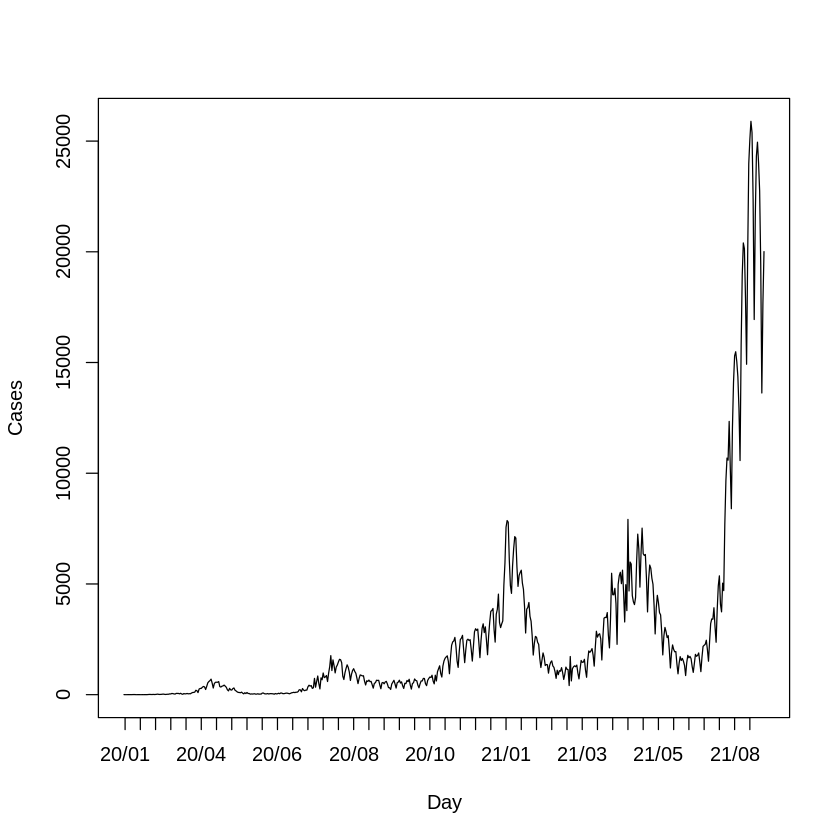

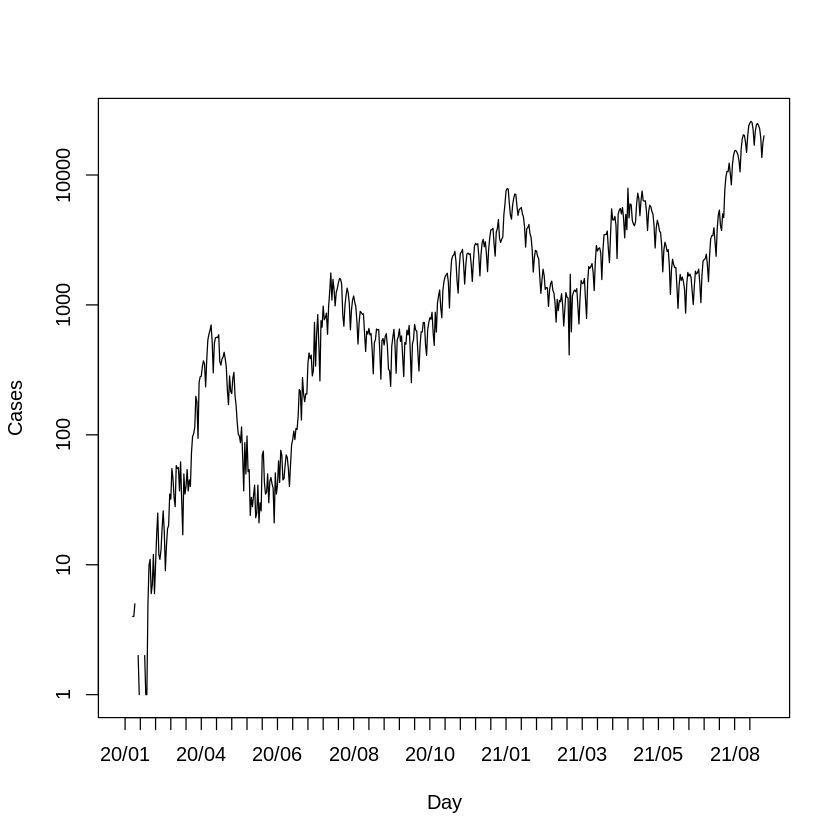


	ADF test

data:  logcases
ADF(5) = -2.6862, p-value = 0.2427
alternative hypothesis: true delta is less than 0
sample estimates:
      delta 
-0.03670463 



	ADF test

data:  diff(logcases)
ADF(5) = -16.329, p-value < 2.2e-16
alternative hypothesis: true delta is less than 0
sample estimates:
    delta 
-2.649853 


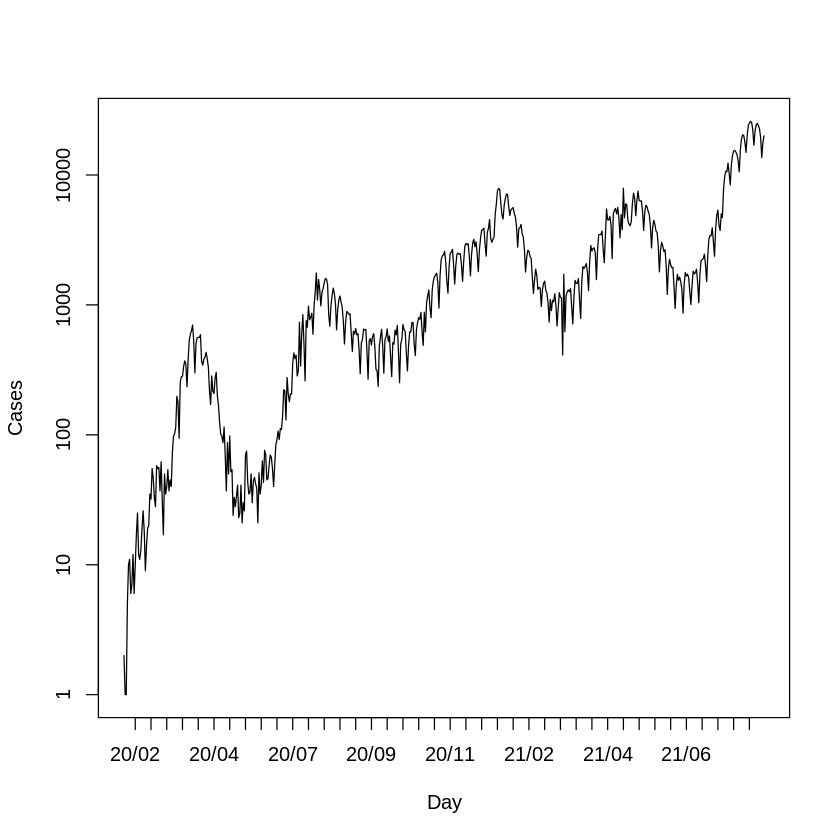

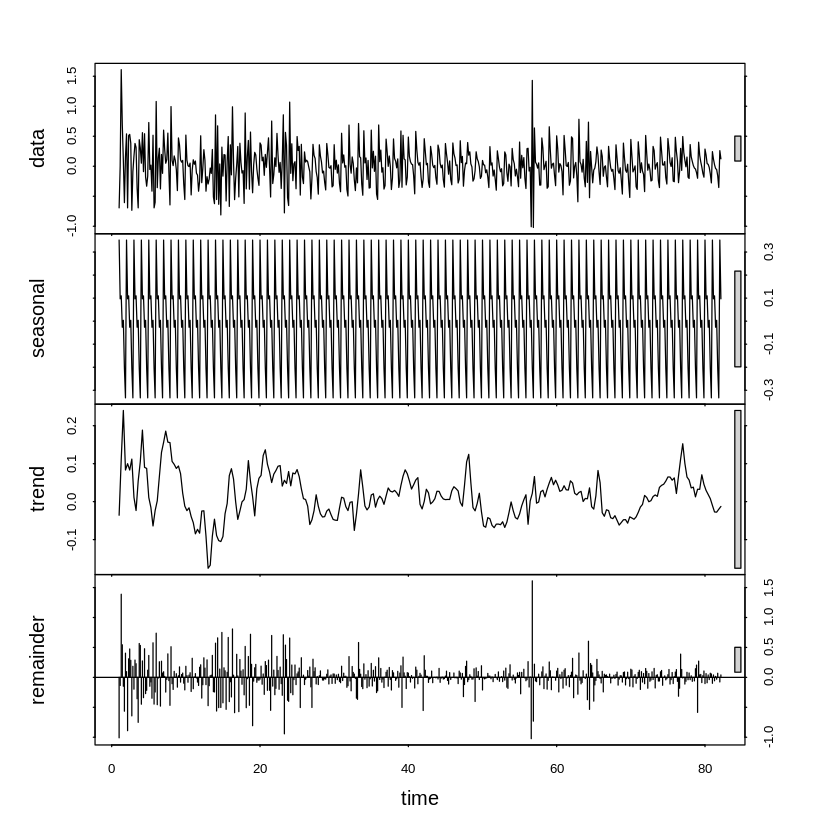

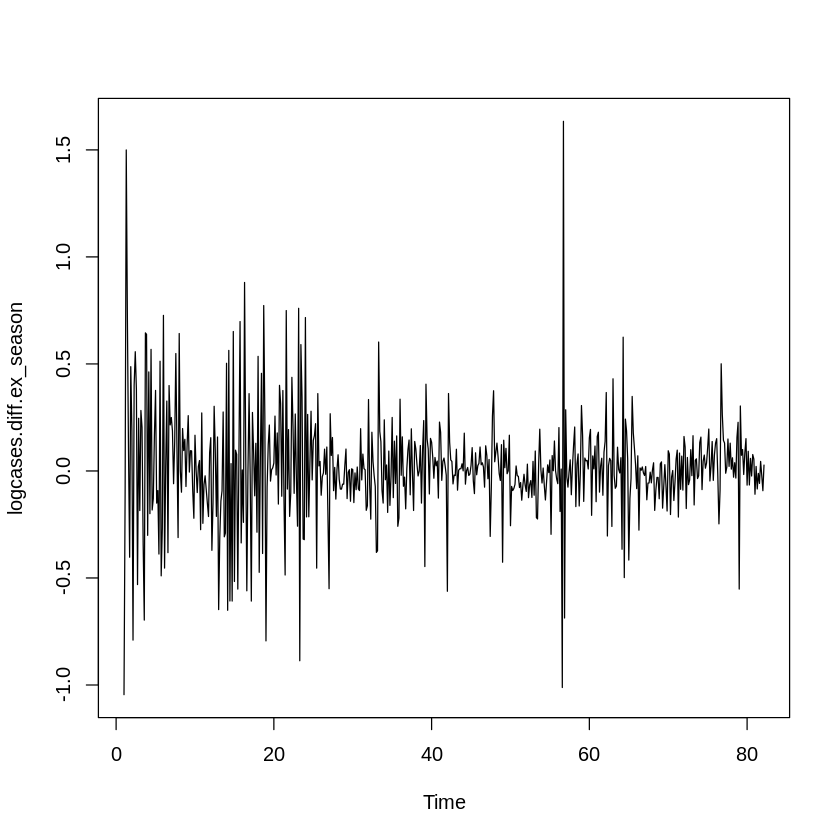

In [16]:
# 3.4 データの観察と変換

# 3.4.1 図示
# データの観察と変換
library(coronavirus)
library(dplyr)
library(tseries)
library(CADFtest)
# 図示
data(coronavirus)
covid.Ja <- coronavirus %>%
  filter(type == "confirmed") %>%
  filter(date <= as.Date("2021/09/01")) %>%
  filter(country == "Japan")
# 描画
plot(covid.Ja$date,covid.Ja$cases,type="l",xlab="Day",ylab="Cases",xaxt ="n")
axis.Date(1,at=covid.Ja$date[as.numeric(covid.Ja$date) %% 14 == 0],format="%y/%m")


# 3.4.2 対数変換
# 片対数グラフをプロット
plot(covid.Ja$date,covid.Ja$cases,log="y", type="l",xlab="Day",ylab="Cases",xaxt ="n")
axis.Date(1,at=covid.Ja$date[as.numeric(covid.Ja$date) %% 14 == 0],format="%y/%m")

# 2020年2月10日以降のデータのみを取り出し片対数グラフでプロット
covid.Ja.nn<- covid.Ja %>% filter(date >= as.Date("2020/02/10"))
plot(covid.Ja.nn$date,covid.Ja.nn$cases,log="y",type="l",xlab="Day",ylab="Cases",xaxt ="n")
axis.Date(1,at=covid.Ja.nn$date[as.numeric(covid.Ja.nn$date) %% 14== 0 ],format="%y/%m")

# 3.4.3 単位根検定
# 対数変換
logcases <- log(covid.Ja.nn$cases)
# ADF検定
CADFtest(logcases,
         type='trend', # トレンド項も定数項もあり
         max.lag.y=5, # ラグの最大次数を指定
         criterion='AIC' # ラグ次数はAIC規準で選ぶ
)

# 差分系列のADF検定
CADFtest(diff(logcases),
         type='trend', # トレンド項も定数項もあり
         max.lag.y=5, # ラグの最大次数を指定
         criterion='AIC' # ラグ次数はAIC規準で選ぶ
)

# 3.4.4 季節調整
# 季節成分とトレンドとそれ以外に分解する
logcases.diff.stl<-stl(ts(diff(logcases), frequency=7),s.window="periodic")
plot(logcases.diff.stl)
# 季節調整後のデータ
logcases.diff.ex_season <-logcases.diff.stl$time.series[,2]+logcases.diff.stl$time.series[,3]
plot(logcases.diff.ex_season)


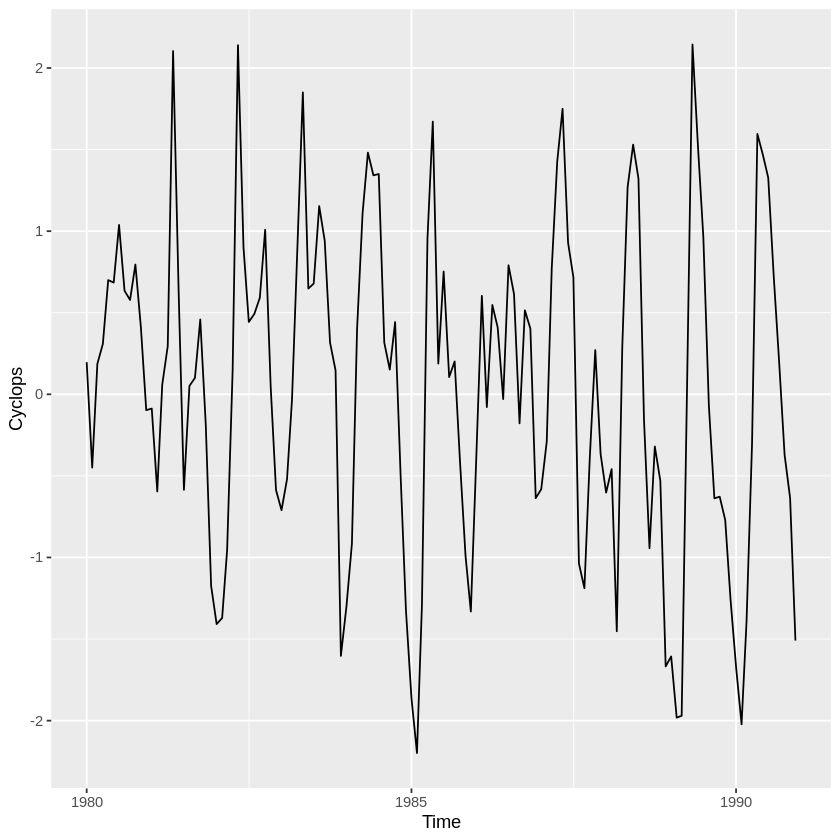


	ADF test

data:  plankdf$Temp
ADF(4) = -10.782, p-value = 6.338e-15
alternative hypothesis: true delta is less than 0
sample estimates:
     delta 
-0.7697244 



	ADF test

data:  plankdf$Cyclops
ADF(3) = -6.9958, p-value = 8.368e-08
alternative hypothesis: true delta is less than 0
sample estimates:
    delta 
-0.646027 



Call:
lm(formula = Cyclops ~ Temp, data = plankdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.86864 -0.71547  0.04696  0.54389  2.10421 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01941    0.07695   0.252    0.801    
Temp         0.45995    0.07700   5.974 2.09e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.8828 on 130 degrees of freedom
Multiple R-squared:  0.2154,	Adjusted R-squared:  0.2093 
F-statistic: 35.68 on 1 and 130 DF,  p-value: 2.087e-08


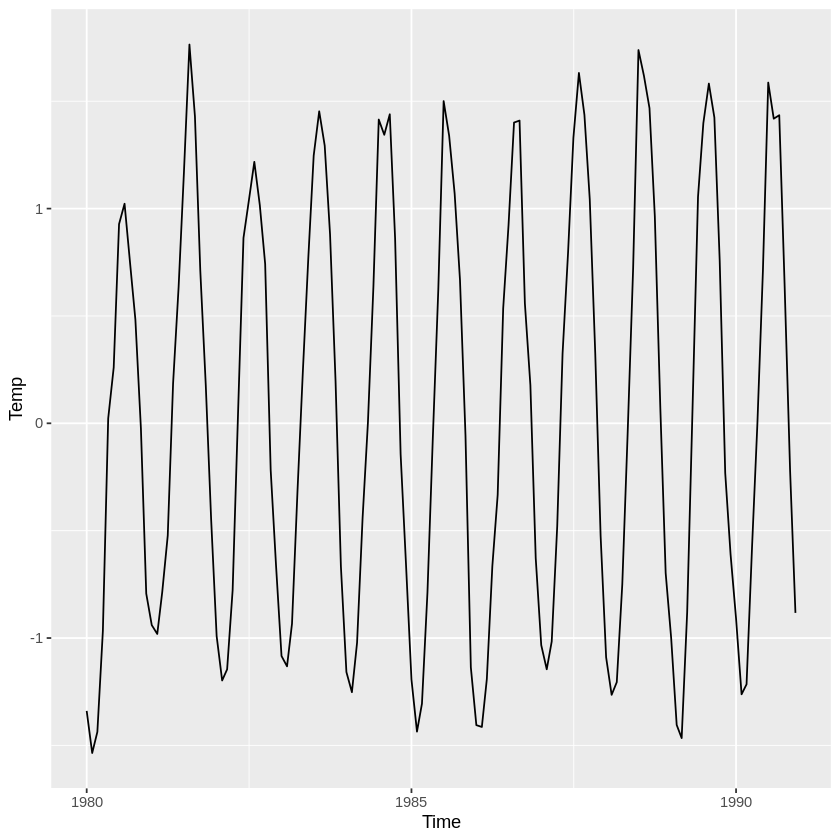


Call:
lm(formula = Cyclops ~ Temp + harmonic(Month, 2, 12), data = plankdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.47464 -0.44781  0.09316  0.45919  1.69959 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.01645    0.05812   0.283  0.77756    
Temp                     0.51676    0.29170   1.772  0.07889 .  
harmonic(Month, 2, 12)1  0.42655    0.35861   1.189  0.23650    
harmonic(Month, 2, 12)2 -0.41653    0.07982  -5.219 7.21e-07 ***
harmonic(Month, 2, 12)3 -0.60013    0.21690  -2.767  0.00651 ** 
harmonic(Month, 2, 12)4  0.18107    0.07969   2.272  0.02478 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.6446 on 126 degrees of freedom
Multiple R-squared:  0.5946,	Adjusted R-squared:  0.5785 
F-statistic: 36.96 on 5 and 126 DF,  p-value: < 2.2e-16


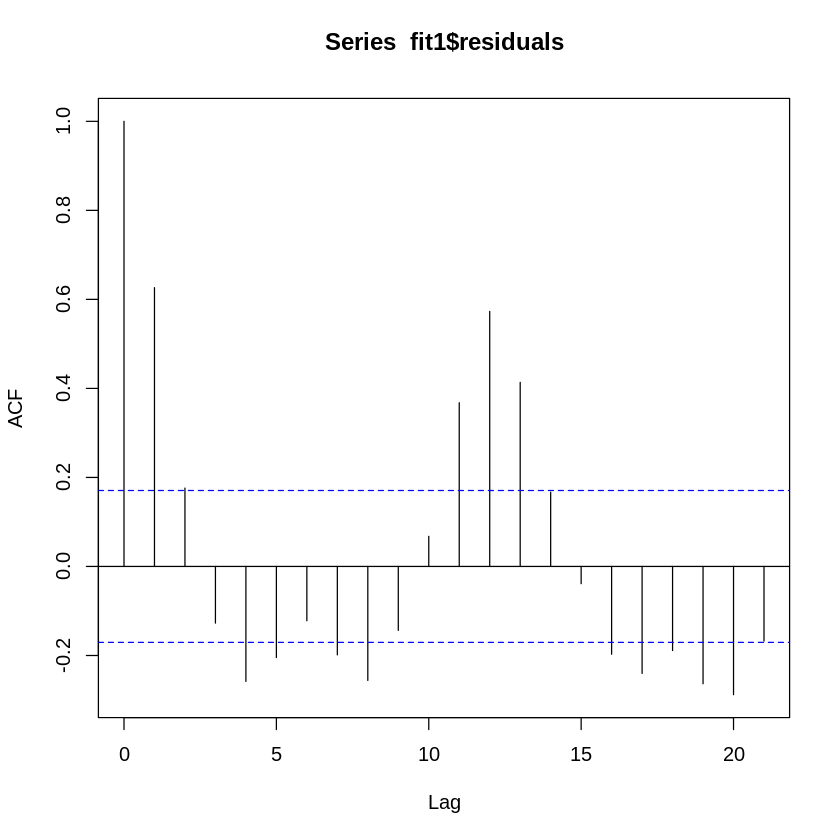


	Durbin-Watson test

data:  fit2
DW = 0.95231, p-value = 1.687e-10
alternative hypothesis: true autocorrelation is greater than 0


Generalized least squares fit by REML
  Model: Cyclops ~ Temp + harmonic(Month, 2, 12) 
  Data: plankdf 
      AIC      BIC   logLik
  242.506 265.1963 -113.253

Correlation Structure: AR(1)
 Formula: ~1 
 Parameter estimate(s):
      Phi 
0.5575261 

Coefficients:
                             Value Std.Error   t-value p-value
(Intercept)              0.0088119 0.1083987  0.081292  0.9353
Temp                     0.8266350 0.2951301  2.800918  0.0059
harmonic(Month, 2, 12)1  0.7802134 0.3726165  2.093878  0.0383
harmonic(Month, 2, 12)2 -0.4399368 0.0788443 -5.579817  0.0000
harmonic(Month, 2, 12)3 -0.3712891 0.2351800 -1.578745  0.1169
harmonic(Month, 2, 12)4  0.2015934 0.0784788  2.568762  0.0114

 Correlation: 
                        (Intr) Temp   h(M,2,12)1 h(M,2,12)2 h(M,2,12)3
Temp                    -0.131                                        
harmonic(Month, 2, 12)1 -0.126  0.951                                 
harmonic(Month, 2, 12)2  0.009 -0.108 -0.101                    

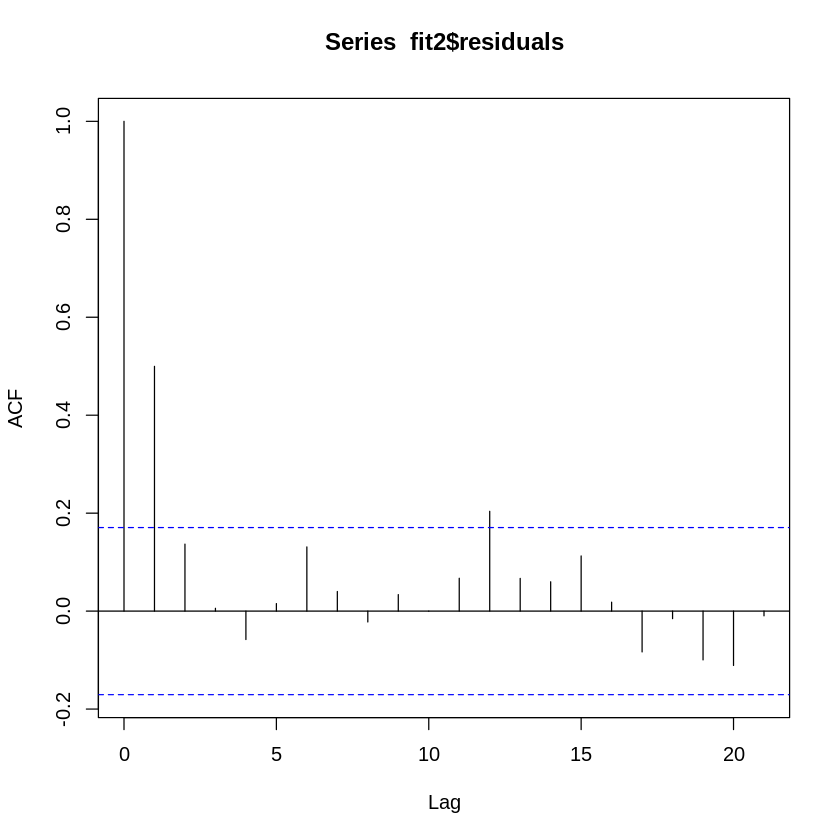

In [17]:
# 3.5 時系列同士の回帰分析

library(MARSS)
library(tseries)
library(tsModel)
library(lmtest)
library(nlme)
library(CADFtest)
library(ggplot2)

# データセットの読み込み
data(lakeWAplankton)
plankdf <- as.data.frame(lakeWAplanktonTrans)

# 1980年から1990年までのデータを抜き出す
plankdf <-subset(plankdf, 1980<=Year & Year <=1990)

# 日付をPOSIXct型にする
plankdf$Time <- as.POSIXct(paste(plankdf$Year,plankdf$Month,1),format="%Y %m %d")

# 描画
g1 <- ggplot(plankdf, aes(x = Time, y = Cyclops))+ geom_line()
plot(g1)
g2 <- ggplot(plankdf, aes(x = Time, y = Temp))+ geom_line()
plot(g2)

# ADF検定（帰無仮説: 単位根を持つ）
CADFtest(plankdf$Temp, type='trend', max.lag.y=4, criterion='AIC')
CADFtest(plankdf$Cyclops, type='trend', max.lag.y=4, criterion='AIC')

# 季節成分を考慮しないOLS回帰
fit1 <- lm(Cyclops ~ Temp, plankdf )
summary(fit1)
acf(fit1$residuals)

# 季節成分を考慮したOLS回帰
fit2 <- lm(Cyclops ~ Temp+ harmonic(Month,2,12), plankdf )
summary(fit2)
acf(fit2$residuals)

# ダービン-ワトソン検定
dwtest(fit2)

# 季節成分を考慮したGLS回帰
fit3 <- gls(Cyclops~ Temp+ harmonic(Month,2,12),correlation = corAR1(),data=plankdf)
summary(fit3)


Linear mixed-effects model fit by REML
  Data: dat 
  Log-restricted-likelihood: -526.7513
  Fixed: weight ~ 1 
(Intercept) 
   337.0083 

Random effects:
 Formula: ~1 | Rat
        (Intercept) Residual
StdDev:    115.1943 14.74502

Number of Observations: 120
Number of Groups: 12 

Linear mixed-effects model fit by REML
  Data: dat 
       AIC      BIC    logLik
  762.9048 787.6871 -372.4524

Random effects:
 Formula: ~Time | Rat
 Structure: General positive-definite, Log-Cholesky parametrization
            StdDev    Corr  
(Intercept) 39.194290 (Intr)
Time         1.612631 0.019 
Residual     4.306175       

Correlation Structure: AR(1)
 Formula: ~Time | Rat 
 Parameter estimate(s):
      Phi 
0.4230404 
Fixed effects:  weight ~ Time * Diet 
                Value Std.Error  DF   t-value p-value
(Intercept) 251.79229 13.908954 106 18.102891   0e+00
Time          2.53776  0.609355 106  4.164672   1e-04
Diet2       201.31398 24.091016  10  8.356392   0e+00
Time:Diet2    4.44604  1.055434 106  4.212525   1e-04
 Correlation: 
           (Intr) Time   Diet2 
Time       -0.006              
Diet2      -0.577  0.004       
Time:Diet2  0.004 -0.577 -0.006

Standardized Within-Group Residuals:
       Min         Q1        Med         Q3        Max 
-2.7253678 -0.4252638

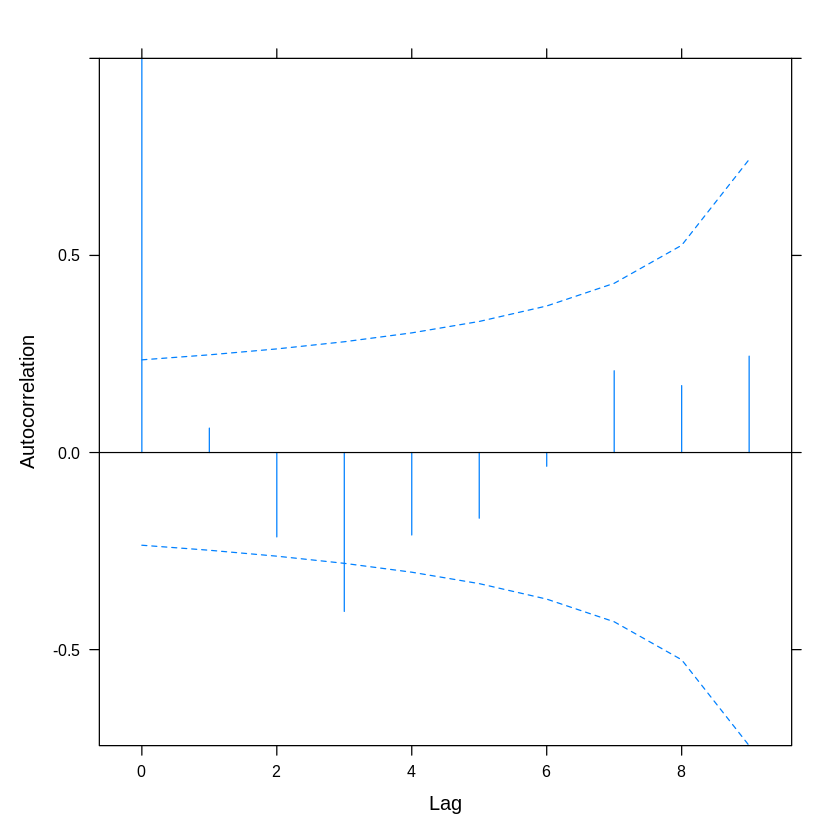

In [18]:
# 3.6 潜在成長曲線モデル

# データセットの準備
library(nlme)
dat <-BodyWeight[BodyWeight$Diet==1|BodyWeight$Diet==2,]
dat <-dat[dat$Time != 44,] # 等間隔で記録されていないデータを除外
dat$Time <- (dat$Time-1)/7 # 週の値に変換
dat <- data.frame(dat)

# ランダム切片モデル
library(nlme)
lme(weight ~ 1, random = ~ 1 | Rat, data=dat)
# library(lme4) # {lme4}で書く場合
# lmer(weight ~ 1 + (1 | Rat), data = dat)

# 残差の系列相関を考慮しない潜在成長曲線モデル
fit1 <- lme(weight ~ Time*Diet, random = ~ Time | Rat, data=dat)
plot(ACF(fit1), alpha = 0.01)

# 残差の系列相関を考慮した潜在成長曲線モデル
fit2 <- lme(weight ~ Time*Diet, random = ~ Time | Rat,
            correlation = corAR1(form=~Time|Rat), data=dat)
summary(fit2)



Call:
glm(formula = aces ~ smokban * time, family = gaussian, data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-98.957  -38.575   -4.926   35.513  158.337  

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   728.4730    18.9129  38.517  < 2e-16 ***
smokban      -117.7339    86.7176  -1.358    0.180    
time            4.4534     0.8914   4.996 6.28e-06 ***
smokban:time    0.6879     1.9609   0.351    0.727    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 3086.966)

    Null deviance: 304139  on 58  degrees of freedom
Residual deviance: 169783  on 55  degrees of freedom
AIC: 647.35

Number of Fisher Scoring iterations: 2


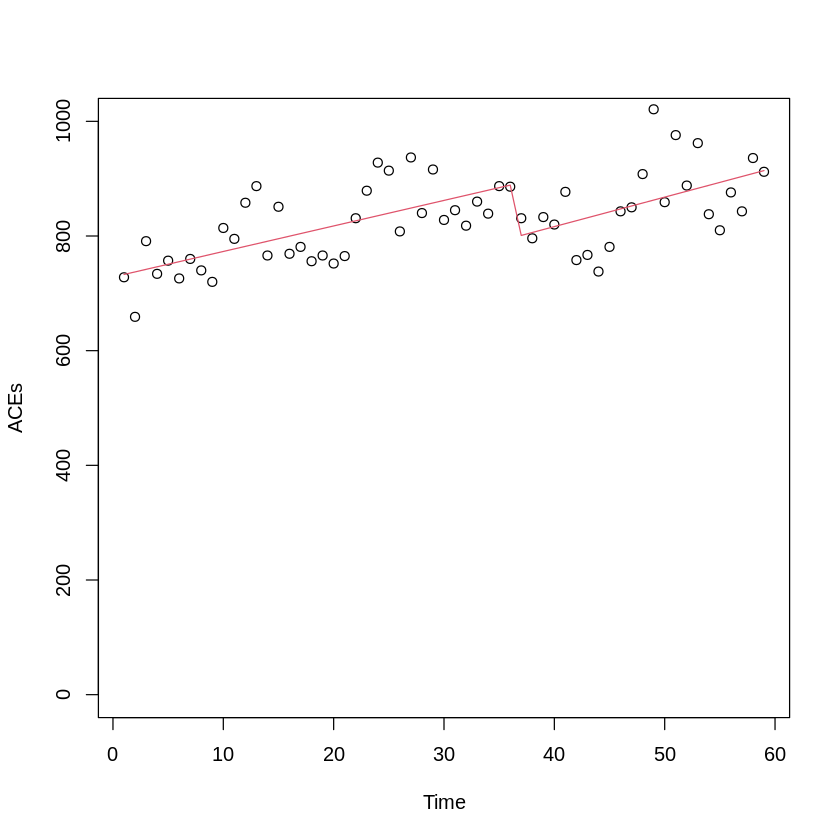


Call:
glm(formula = aces ~ smokban * time + harmonic(time, 2, 12), 
    family = gaussian, data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-101.813   -31.998    -2.868    30.220   115.755  

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             723.5625    15.2572  47.424  < 2e-16 ***
smokban                -168.9090    70.4881  -2.396 0.020268 *  
time                      4.7188     0.7241   6.517 3.15e-08 ***
harmonic(time, 2, 12)1   33.5705     8.4688   3.964 0.000230 ***
harmonic(time, 2, 12)2  -13.4729     8.1040  -1.663 0.102547    
harmonic(time, 2, 12)3   32.7385     8.1625   4.011 0.000198 ***
harmonic(time, 2, 12)4   11.9229     8.1625   1.461 0.150235    
smokban:time              1.6314     1.5682   1.040 0.303124    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 1920.457)

    Null deviance: 304139  on 58  degr

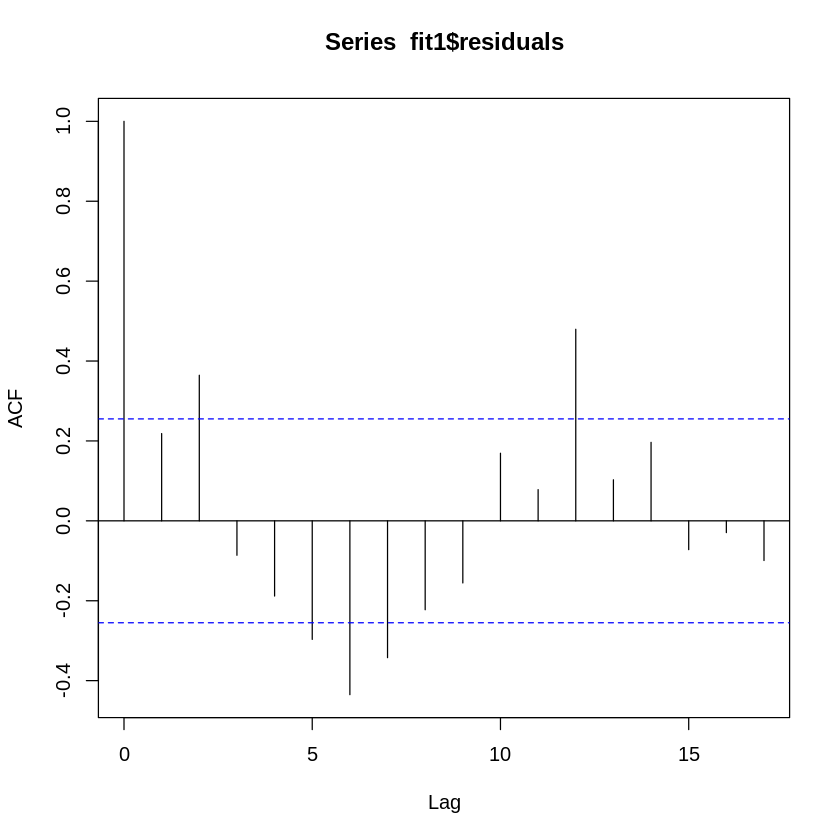


	Durbin-Watson test

data:  fit2
DW = 2.4659, p-value = 0.8262
alternative hypothesis: true autocorrelation is greater than 0



Call:
glm(formula = aces ~ smokban * time, family = poisson(link = "log"), 
    data = data)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-3.477  -1.339  -0.270   1.245   5.261  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   6.5947956  0.0122556 538.103   <2e-16 ***
smokban      -0.1294175  0.0537370  -2.408    0.016 *  
time          0.0054958  0.0005640   9.745   <2e-16 ***
smokban:time  0.0005017  0.0012130   0.414    0.679    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 365.47  on 58  degrees of freedom
Residual deviance: 202.51  on 55  degrees of freedom
AIC: 715.23

Number of Fisher Scoring iterations: 3


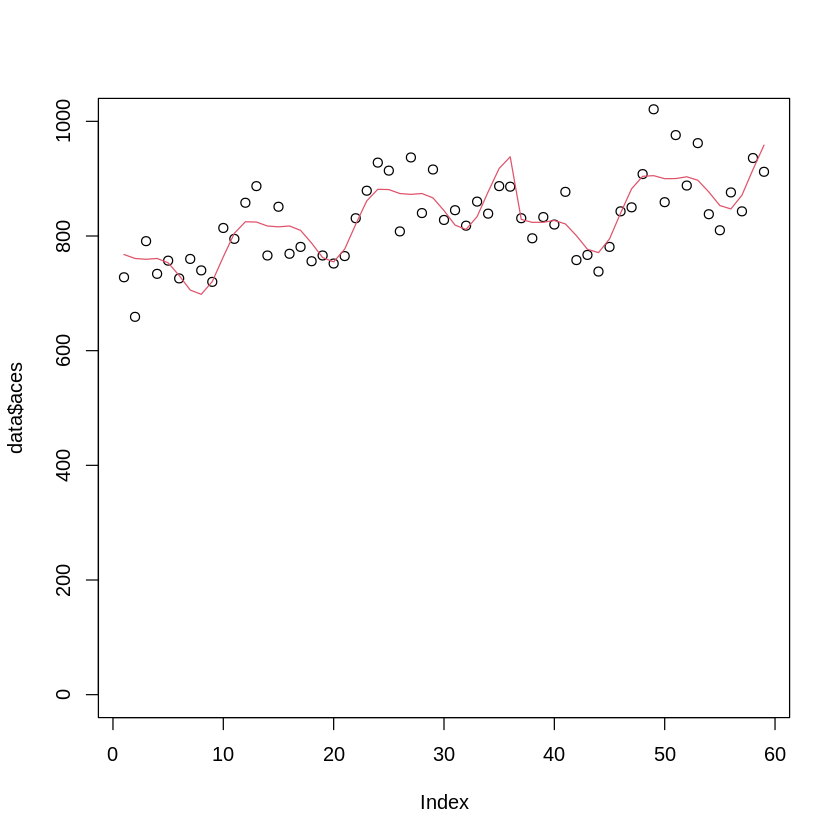

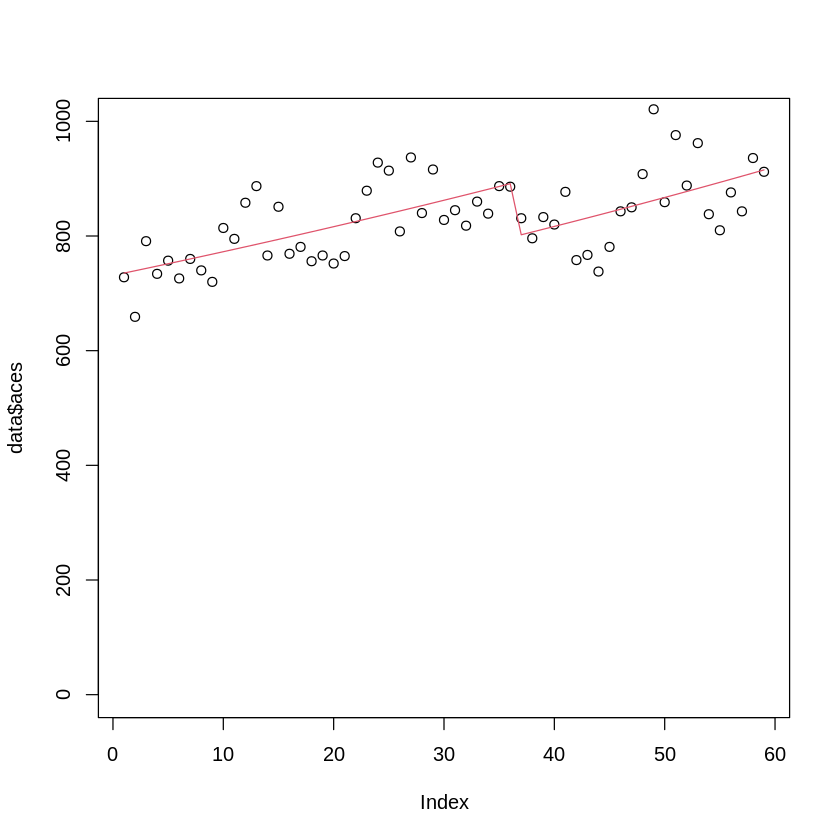


Call:
glm(formula = aces ~ smokban * time + harmonic(time, 2, 12), 
    family = poisson(link = "log"), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7661  -1.1144  -0.1596   1.1097   3.7279  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             6.588158   0.012520 526.222  < 2e-16 ***
smokban                -0.191619   0.055401  -3.459 0.000543 ***
time                    0.005805   0.000580  10.009  < 2e-16 ***
harmonic(time, 2, 12)1  0.041261   0.006743   6.119 9.43e-10 ***
harmonic(time, 2, 12)2 -0.016417   0.006429  -2.554 0.010664 *  
harmonic(time, 2, 12)3  0.039241   0.006441   6.092 1.11e-09 ***
harmonic(time, 2, 12)4  0.013952   0.006466   2.158 0.030940 *  
smokban:time            0.001657   0.001230   1.347 0.177925    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 365.47  on 58  degrees o


Call:
glm(formula = aces ~ offset(log(stdpop)) + smokban * time + harmonic(time, 
    2, 12), family = poisson(link = "log"), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.7028  -1.1977  -0.1371   1.1837   3.6172  

Coefficients:
                         Estimate Std. Error  z value Pr(>|z|)    
(Intercept)            -6.2469039  0.0125164 -499.097  < 2e-16 ***
smokban                -0.1852194  0.0554057   -3.343 0.000829 ***
time                    0.0051026  0.0005799    8.800  < 2e-16 ***
harmonic(time, 2, 12)1  0.0383261  0.0067424    5.684 1.31e-08 ***
harmonic(time, 2, 12)2 -0.0176326  0.0064294   -2.743 0.006097 ** 
harmonic(time, 2, 12)3  0.0383558  0.0064410    5.955 2.60e-09 ***
harmonic(time, 2, 12)4  0.0149653  0.0064664    2.314 0.020650 *  
smokban:time            0.0014822  0.0012297    1.205 0.228076    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

   

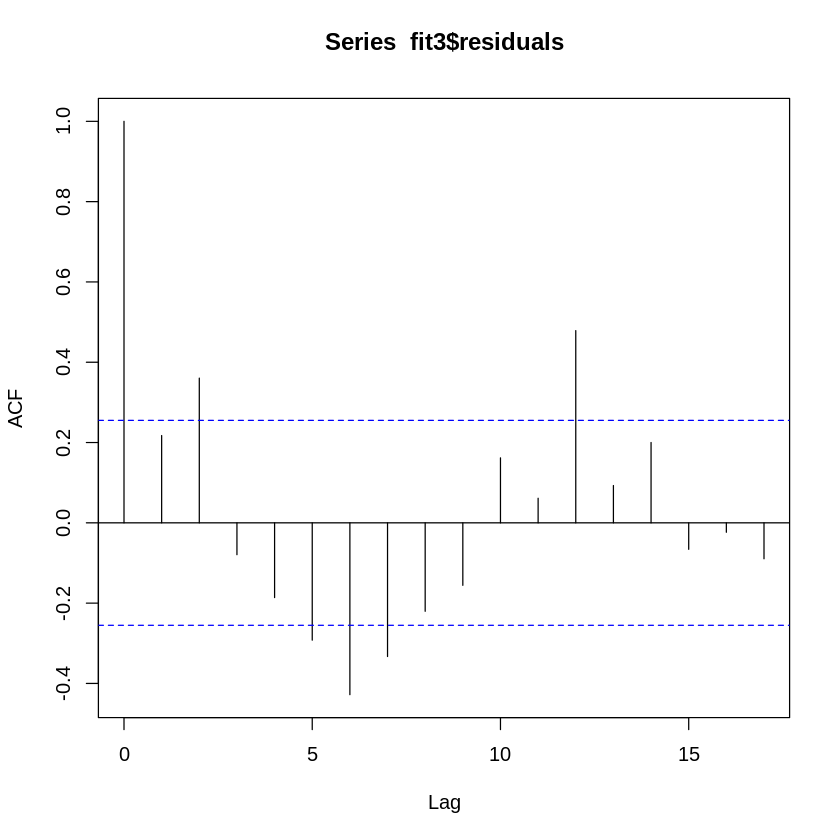

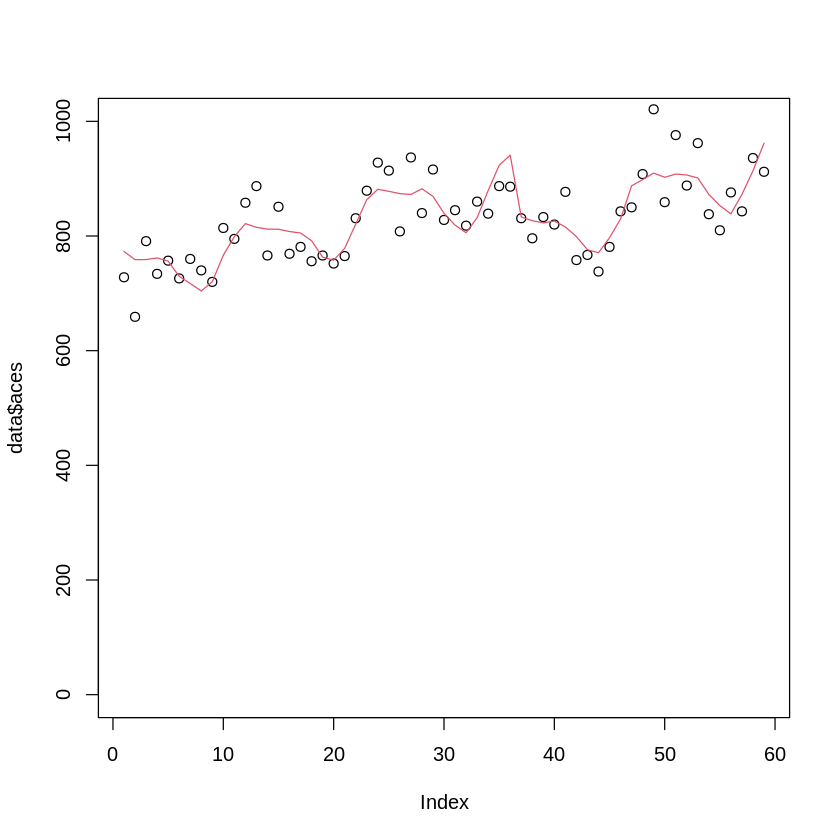

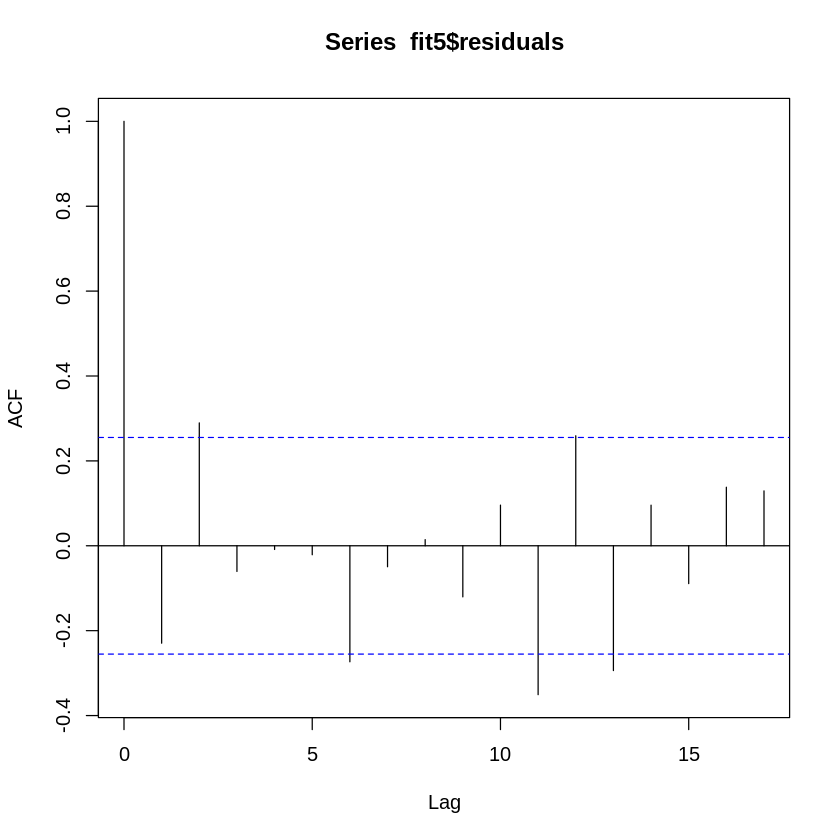

In [22]:
# 3.7 中断時系列デザイン

# データの準備
fileURL <- "https://raw.githubusercontent.com/gasparrini/2017_lopezbernal_IJE_codedata/master/sicily.csv"
data <- data.frame(read.csv(fileURL, header=T))

# 一般線形モデル（線形回帰）介入×時間

# 傾きの変化を考慮したモデル
fit1 <- glm(aces ~ smokban * time , family=gaussian, data)

# 傾きの変化を考慮しないモデル
# fit1 <- glm(aces ~ smokban + time , family=gaussian, data)

summary(fit1)

# 描画
pred1 <- predict(fit1) # 予測
plot(data$aces, ylim=c(0,1000),xlab="Time", ylab="ACEs")
points(pred1, col=2, type="l")

# 自己相関関数
acf(fit1$residuals)


# 一般線形モデル（線形回帰）介入×時間＋季節成分
library(tsModel)
# harmonic(time,2,12)の2番目の引数で調和数，3番目の引数で周期を指定します
fit2 <- glm(aces ~ smokban * time + harmonic(time,2,12) , family=gaussian, data)
summary(fit2)

# 描画
pred2 <- predict(fit2)
plot(data$aces, ylim=c(0,1000))
points(pred2, col=2, type="l")

# ダービン-ワトソン検定
library(lmtest)
dwtest(fit2)


# 一般線形モデル（ポアソン回帰）介入×時間
fit3 <- glm(aces ~ smokban*time, family=poisson(link="log"), data)
summary(fit3)
# 描画
pred3 <- predict(fit3)
plot(data$aces, ylim=c(0,1000))
points(exp(pred3), col=2, type="l")
acf(fit3$residuals)


# 一般線形モデル（ポアソン回帰）介入×時間＋季節成分
fit4 <- glm(aces ~ smokban*time + harmonic(time,2,12), family=poisson(link="log"), data)
summary(fit4)


# 一般線形モデル（ポアソン回帰）オフセット項+介入×時間＋季節成分
# 人口stdpopをオフセット項として投入している
fit5 <- glm(aces ~ offset(log(stdpop)) + smokban*time + harmonic(time,2,12),family=poisson(link="log"), data)
summary(fit5)

# 描画
pred5 <- predict(fit5)
plot(data$aces, ylim=c(0,1000))
points(exp(pred5), col=2, type="l")
acf(fit5$residuals)